##Set TensorFlow version

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Download data and unzip

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/cat_dog.zip \
    -O cat_dog.zip

--2020-05-06 02:41:36--  https://storage.googleapis.com/ai_data_colab/cat_dog.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227743931 (217M) [application/zip]
Saving to: ‘cat_dog.zip’

cat_dog.zip         100%[===================>] 217.19M  38.0MB/s    in 5.7s    

2020-05-06 02:41:43 (38.0 MB/s) - ‘cat_dog.zip’ saved [227743931/227743931]



In [0]:
import os
import zipfile

local_zip = 'cat_dog.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [0]:
train_cat_dir = os.path.join('cat_dog/train/cat')
train_dog_dir = os.path.join('cat_dog/train/dog')
test_cat_dir = os.path.join('cat_dog/test/cat')
test_dog_dir = os.path.join('cat_dog/test/dog')

print('total training cat images:', len(os.listdir(train_cat_dir)))
print('total training dog images:', len(os.listdir(train_dog_dir)))
print('total testing cat images:', len(os.listdir(test_cat_dir)))
print('total testing dog images:', len(os.listdir(test_dog_dir)))

test_cat_files = os.listdir(test_cat_dir)
print(test_cat_files[:5])
test_dog_files = os.listdir(test_dog_dir)
print(test_dog_files[:5])

total training cat images: 4000
total training dog images: 4000
total testing cat images: 1000
total testing dog images: 1000
['cat.4436.jpg', 'cat.4345.jpg', 'cat.4913.jpg', 'cat.4271.jpg', 'cat.4825.jpg']
['dog.4434.jpg', 'dog.4496.jpg', 'dog.4945.jpg', 'dog.4548.jpg', 'dog.4076.jpg']


##Import libraries

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Build the model with pretrained model

In [0]:
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(150,150,3))
vgg16.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

In [0]:
unfreeze = ['block5_conv1', 'block5_conv2', 'block5_conv3'] # 最後 3 層的名稱

for layer in vgg16.layers:
    if layer.name in unfreeze:
        layer.trainable = True  # unfreeze the last 3 layers
    else:
        layer.trainable = False # freeze the other layers

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
model = Sequential()
model.add(vgg16)    # use vgg16 as the first layer
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=1e-5),   # lower the learning rate
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 11,274,753
Non-trainable params: 7,635,264
_________________________________________________________________


##Data augmentation

In [0]:
gobj = ImageDataGenerator(rescale=1./255, validation_split=0.75, #use fewer training data in this transfer learning case on purpose
    rotation_range=40,     
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=10,         
    zoom_range=0.2,        
    horizontal_flip=True)  

trn_gen = gobj.flow_from_directory( 
    'cat_dog/train',         
    target_size=(150, 150),  
    batch_size=50,        
    class_mode='binary',    
    subset='training')      

Found 2000 images belonging to 2 classes.


In [0]:
gobj = ImageDataGenerator(rescale=1./255)  

val_gen = gobj.flow_from_directory( 
    'cat_dog/test',          
    target_size=(150, 150),
    batch_size=50,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


##Train the model

In [0]:
history = model.fit(trn_gen,        
                    epochs=30, verbose=1,
                    validation_data=val_gen)

Epoch 1/30
40/40 [==============================] - 28s 691ms/step - loss: 0.5778 - acc: 0.7010 - val_loss: 0.4127 - val_acc: 0.8270
Epoch 2/30
40/40 [==============================] - 20s 494ms/step - loss: 0.4318 - acc: 0.8080 - val_loss: 0.3134 - val_acc: 0.8690
Epoch 3/30
40/40 [==============================] - 20s 495ms/step - loss: 0.3652 - acc: 0.8395 - val_loss: 0.2734 - val_acc: 0.8845
Epoch 4/30
40/40 [==============================] - 20s 489ms/step - loss: 0.3296 - acc: 0.8550 - val_loss: 0.2629 - val_acc: 0.8805
Epoch 5/30
40/40 [==============================] - 20s 493ms/step - loss: 0.3020 - acc: 0.8655 - val_loss: 0.2743 - val_acc: 0.8890
Epoch 6/30
40/40 [==============================] - 20s 492ms/step - loss: 0.2913 - acc: 0.8705 - val_loss: 0.2286 - val_acc: 0.8960
Epoch 7/30
40/40 [==============================] - 20s 494ms/step - loss: 0.2755 - acc: 0.8795 - val_loss: 0.2242 - val_acc: 0.8995
Epoch 8/30
40/40 [==============================] - 20s 492ms/step - 

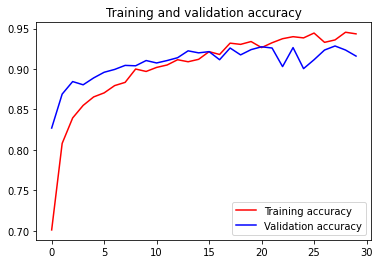

<Figure size 432x288 with 0 Axes>

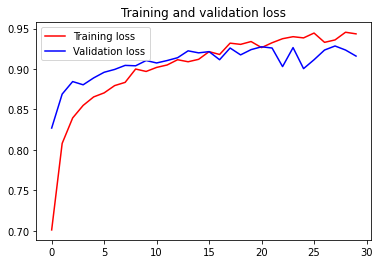

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, acc, 'r', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Reference: https://www.tensorflow.org/tutorials/images/transfer_learning